In [1]:
import time
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, KFold

from graspy.simulations import sbm
from graspy.embed import MultipleASE, OmnibusEmbed
from graspy.plot import heatmap, pairplot
from graspy.utils import symmetrize

from rerf.rerfClassifier import rerfClassifier

from tqdm import tqdm_notebook as tqdm

%matplotlib inline

In [2]:
def generate_data(n=10, alpha=0.1, seed=None):
    np.random.seed(seed)
    
    C1 = [[.1, 0],
          [0, .1]]
    C2 = [[-.1, 0],
          [0, -.1]]
    C3 = [[.1, 0],
          [0, 0]]
    C4 = [[0, 0],
          [0, .1]]
    
    ones = np.ones((2, 2)) * .25
    
    out = []
    for C in [C1, C2, C3, C4]:
        for _ in range(n):
            p = ones + alpha * np.array(C)
            out.append(sbm(n=[128, 128], p=p))
            
    labels = np.repeat([0, 1, 2, 3], n)
        
    return np.array(out), labels

In [3]:
def run_srerf(XTRAIN, YTRAIN, XTEST, YTEST):
    XTRAIN = XTRAIN.copy().reshape(40, -1)
    XTEST = XTEST.copy().reshape(40, -1)

    cls = rerfClassifier(
        projection_matrix="S-RerF",
        max_features=40,
        n_jobs=8,
        n_estimators=500,
        oob_score=False,
        random_state=None,
        image_height=256,
        image_width=256,
        patch_height_max=16,
        patch_height_min=1,
        patch_width_max=16,
        patch_width_min=1
    )
    
    cls.fit(XTRAIN, YTRAIN)
    
    preds = np.array(cls.predict(XTEST))
    error = np.mean(preds != YTEST)
    
    return error

def run_rerf(XTRAIN, YTRAIN, XTEST, YTEST):
    idx = np.triu_indices(256, k=1)
    
    n_features = XTRAIN.shape[1]
    
    XTRAIN = np.array([x[idx] for x in XTRAIN])
    XTEST = np.array([x[idx] for x in XTEST])

    cls = rerfClassifier(
        projection_matrix="RerF",
        n_jobs=8,
        max_features=n_features,
        n_estimators=500,
        oob_score=False,
        random_state=None,
    )
    
    cls.fit(XTRAIN, YTRAIN)
    
    preds = np.array(cls.predict(XTEST))
    error = np.mean(preds != YTEST)
    
    return error

def run_mase(XTRAIN, YTRAIN, XTEST, YTEST):
    X = np.vstack([XTRAIN, XTEST])
    
    mase = MultipleASE(n_components=2, scaled=True)
    mase.fit(X)
    
    rhats = mase.scores_.reshape(80, -1)
    
    knn = KNeighborsClassifier(n_neighbors=1, metric='euclidean')
    knn.fit(rhats[:40], YTRAIN)
    
    preds = knn.predict(rhats[40:])
    error = np.mean(preds != YTEST)
    
    return np.mean(error)


def run_g_edge_morf(XTRAIN, YTRAIN, XTEST, YTEST):
    XTRAIN = XTRAIN.copy().reshape(40, -1)
    XTEST = XTEST.copy().reshape(40, -1)

    cls = rerfClassifier(
        projection_matrix="Graph-Edge-MORF",
        max_features=40,
        n_jobs=8,
        n_estimators=500,
        oob_score=False,
        random_state=None,
        image_height=256,
        image_width=256,
        patch_height_max=16,
        patch_height_min=1,
        patch_width_max=16,
        patch_width_min=1
    )
    
    cls.fit(XTRAIN, YTRAIN)
    
    preds = np.array(cls.predict(XTEST))
    error = np.mean(preds != YTEST)
    
    return error

def run_g_node_morf(XTRAIN, YTRAIN, XTEST, YTEST):
    XTRAIN = XTRAIN.copy().reshape(40, -1)
    XTEST = XTEST.copy().reshape(40, -1)

    cls = rerfClassifier(
        projection_matrix="Graph-Node-MORF",
        max_features=40,
        n_jobs=8,
        n_estimators=500,
        oob_score=False,
        random_state=None,
        image_height=256,
        image_width=256,
        patch_height_max=16,
        patch_height_min=1,
        patch_width_max=16,
        patch_width_min=1
    )
    
    cls.fit(XTRAIN, YTRAIN)
    
    preds = np.array(cls.predict(XTEST))
    error = np.mean(preds != YTEST)
    
    return error

def run_srerf_permuted(XTRAIN, YTRAIN, XTEST, YTEST):
    idx = np.arange(XTRAIN.shape[1])
    np.random.shuffle(idx)
    
    XTRAIN = np.array([x[np.ix_(idx, idx)] for x in XTRAIN])
    XTEST = np.array([x[np.ix_(idx, idx)] for x in XTEST])


    XTRAIN = XTRAIN.copy().reshape(40, -1)
    XTEST = XTEST.copy().reshape(40, -1)

    cls = rerfClassifier(
        projection_matrix="S-RerF",
        max_features=40,
        n_jobs=8,
        n_estimators=500,
        oob_score=False,
        random_state=None,
        image_height=256,
        image_width=256,
        patch_height_max=16,
        patch_height_min=1,
        patch_width_max=16,
        patch_width_min=1
    )
    
    cls.fit(XTRAIN, YTRAIN)
    
    preds = np.array(cls.predict(XTEST))
    error = np.mean(preds != YTEST)
    
    return error


def run_classification(alpha):
    XTRAIN, YTRAIN = generate_data(alpha=alpha)
    XTEST, YTEST = generate_data(alpha=alpha)
    
    data = [XTRAIN, YTRAIN, XTEST, YTEST]

    srerf_error = run_srerf(*data)

    rerf_error = run_rerf(*data)

    mase_error = run_mase(*data)

    g_edge_morf_error = run_g_edge_morf(*data)
    
    g_node_morf_error = run_g_node_morf(*data)

    srerf_permuted_error = run_srerf_permuted(*data)

    return srerf_error, rerf_error, mase_error, g_edge_morf_error, g_node_morf_error, srerf_permuted_error

In [4]:
alphas = np.arange(0, 2.01, .05)

start_time = time.time()
runs = []
for _ in tqdm(range(50)):
    loop_time = time.time()
    errors = []
    for alpha in alphas:
        errors.append(run_classification(alpha))
    runs.append(errors)
    #print(np.array(errors).mean(axis=0))\
    print("%s seconds" % (time.time() - loop_time))
    

print("Total: --- %s seconds ---" % (time.time() - start_time))

43.02533173561096 seconds
42.75400900840759 seconds
46.03564786911011 seconds
46.78070569038391 seconds
49.36416292190552 seconds
46.85262060165405 seconds
46.32849907875061 seconds
46.40732717514038 seconds
48.37647247314453 seconds
46.3439085483551 seconds
46.06427836418152 seconds
46.43934440612793 seconds
46.7384614944458 seconds
46.50404167175293 seconds
46.32440185546875 seconds
46.50049090385437 seconds
46.530494689941406 seconds
46.313098430633545 seconds
46.61154222488403 seconds
46.8161084651947 seconds
46.20634984970093 seconds
46.55979609489441 seconds
46.7290461063385 seconds
46.36371374130249 seconds
46.73115634918213 seconds
47.720492124557495 seconds
46.18369483947754 seconds
47.57430386543274 seconds
47.00063729286194 seconds
47.04771828651428 seconds
47.101635694503784 seconds
47.32248020172119 seconds
46.524107933044434 seconds
47.34420394897461 seconds
46.74969720840454 seconds
46.62283134460449 seconds
46.520498752593994 seconds
46.510154485702515 seconds
47.695811

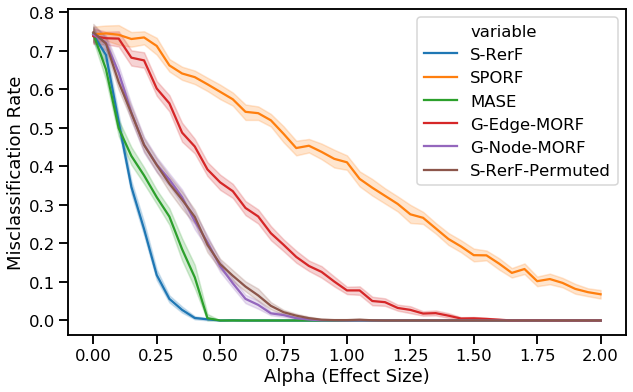

In [5]:
res = np.vstack(runs)
res = np.hstack([res, np.tile(alphas, 50).reshape(-1, 1)])

columns = ['S-RerF', 'SPORF', 'MASE', 'G-Edge-MORF', 'G-Node-MORF', 'S-RerF-Permuted', 'Alpha']
df = pd.DataFrame(res, columns=columns)
df_ = df.melt(id_vars='Alpha', value_vars=columns[:6])

df.to_csv("results_grerf.csv", index=False)

with sns.plotting_context("talk"):
    fig, ax = plt.subplots(figsize=(10, 6))
    sns.lineplot(data=df_, x = 'Alpha', y='value', hue='variable', ax=ax)
    ax.set_ylabel("Misclassification Rate")
    ax.set_xlabel("Alpha (Effect Size)")

In [6]:
fig.savefig("results.pdf", bbox_inches='tight')